# Quantifying anharmonicity in molecular simulations

This is a notebook to illustrate how we can extract and quantify higher-order statistics, and in particular fourth order statistics from molecular dynamics simulations. The tutorial assumes familiarity with Python and numpy arrays. In addition, it also assumes that you have a working copy of the code as well as its dependencies such as mdanalysis.

In [1]:
# set up some initial libraries that we want as part of this set up
%matplotlib inline
import matplotlib.pyplot as plt;
import numpy as np;
import MDAnalysis as mdanal;

In [2]:
# to generate pretty plots
plt.style.use('ggplot');

## Select coordinates of interest
The function below is a generic driver for obtaining coordinates of interest. The line with `Ca` specifies the coordinates selected, and is based on `MDAnalysis` selection [syntax](http://pythonhosted.org/MDAnalysis/documentation_pages/selections.html). You can use a variety of atom selections that can be returned as a `numpy` array.   

In [3]:
# a top level function to get the coordinates of interest
def getCoordinates(pdbFileName, trjFileName, step):
    '''
    @pdbFileName: string denotes the file name of the topology file. 
    Assumes that the corect ordering of residues and names of all atoms. 
    @trjFileName: string denotes the name of teh trajectories being processed.
    @step: int specifies the steps to jump in order to not process a large trajectory.
    '''
    u = mdanal.Universe(pdbFileName, trjFileName, permissive=False); # universe is the top level object for MD
    frames = [];
    Ca = u.select_atoms('name CA'); # selection is based on calpha atoms. 
    for ts in u.trajectory[::step]:
        frames.append(Ca.positions.T);
    return np.array(frames);

We import our main library called Anharmonic conformational analysis (anca). Anca provides a number of functions that allows one to measure anharmonicity from MD simulations. Here we demonstrate the use of `anca` in quantifying fourth order statistics for (a) the whole simulation and (b) identifying which residues spend significant time exhibhting anharmonic fluctuations. 

In [4]:
import anca

In [8]:
CA_hivp = getCoordinates('../../data/hivp.pdb', '../../data/hivp_aligned.dcd', 1); # get coordinates from the simulation of interest

Nc = CA_hivp.shape[0]; # number of conformers in the simulation
dim = CA_hivp.shape[1]; # number of dimensions - usually 3
Na = CA_hivp.shape[2]; # number of atoms in the selection (from line 3)

## Align coordinates
We need to align the selected coordinates from line 5 above. This is to ensure that we have removed the translations and rotations and have a set of coordinates on which we can perform our analysis. `anca` provides support for two types of coordinate alignments: (1) The standard Kabsch alignment, and (2) an iterative alignment algorithm. You can use either function to align your trajectories. 

**Note**: We assume that you have taken care of putting protein chains or independent molecules together in the trajectories before aligning them. There are lots of pointers available, for e.g., in VMD you can use (PBCTools)[http://www.ks.uiuc.edu/Research/vmd/plugins/pbctools/]. Depending on which software you used for your simulations the procedures for putting together individual chains or molecules can be different. 

In [9]:
from anca import IterativeMeansAlign
iterAlign = IterativeMeansAlign.IterativeMeansAlign();
[itr, avgCoordsAll, eRMSDAll, newCoordsAll] = iterAlign.iterativeMeans(CA_hivp, 0.001, 12);

No handlers could be found for logger "main.IterativeMeansAlign"


In [11]:
coordsAll = np.reshape(newCoordsAll, (len(newCoordsAll), dim*Na)).T; 
avgCoordsAll = np.mean(coordsAll, 1); #print avgCoords;
tmpAll = np.reshape(np.tile(avgCoordsAll, 25000), (25000,dim*Na)).T; 
caDevsMDall = coordsAll - tmpAll;
print caDevsMDall.shape;

(594, 25000)


## Generate fourth-order statistical profile for simulations
After aligning the coordinates, one can generate a plot shown below that provides insights into the overall anharmonicity in the simulations, quantified by kurtosis, $\kappa$. The plot summarizes a histogram of C$^\alpha$ atomic deviations from a MD simulation of HIV-protease. The data represents a total of 5$\mu$s simulation and has only $25,000$ conformers (representing conformers every 0.2 ns). The tails from the simulations suggest a significant amount of anharmonicity in the simulation. 

Overall kurtosis for system: 9.86282134158
(52,)


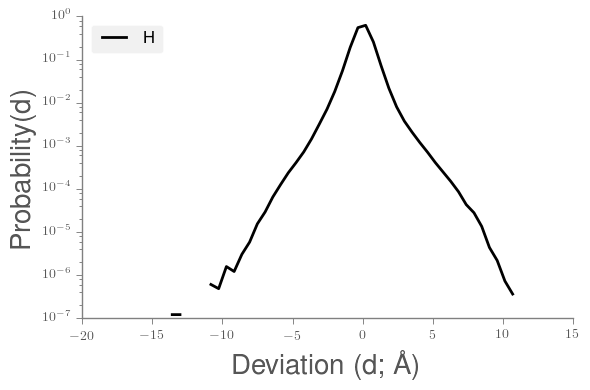

In [12]:
import scipy.stats; 

import os;
os.environ['PATH'] = os.environ['PATH'] + ':/usr/local/texlive/2014/bin/x86_64-darwin/';

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']});
rc('text', usetex=True);

D = caDevsMDall.flatten(); 
[n,s] = np.histogram(D, bins=51,normed=1);
gm = np.mean(D); 
gs = np.std(D);
gK = scipy.stats.kurtosis(D,0,fisher=False);
print 'Overall kurtosis for system: ' + str(gK);
gp = np.exp(-(s-gm)**2/(2*gs*gs));
gp = gp/np.sum(gp); print np.shape(gp);

fig = plt.figure();
ax = plt.subplot(111, axisbg='white');   
ax.spines["top"].set_visible(False); 
ax.spines["bottom"].set_visible(True);
ax.spines["bottom"].set_color('gray');
ax.spines["right"].set_visible(False);    
ax.spines["left"].set_visible(True);
ax.spines["left"].set_color('gray');

ax.get_xaxis().tick_bottom();   
ax.get_yaxis().tick_left();

x = 0.5*(s[1:] + s[:-1]);
ax.hold(True); 
ax.semilogy(x, n, 'k-', linewidth=2.0); 
plt.legend('HIVP', loc=2, fancybox=True, framealpha=0.5);
plt.xlabel('Deviation (d; \AA)', fontsize=20);
plt.ylabel('Probability(d)', fontsize=20);
plt.tight_layout();

#plt.savefig('LongTails-overall-HIV.png', dpi=600);
plt.show();

For reference, we provide the root-mean squared fluctuations from our simulations, shown below. Since the protein has two chains, one can observe the symmetry in the RMSF profiles in HIV-protease. Depending on the system(s) of interest, these plots can be quite different. 

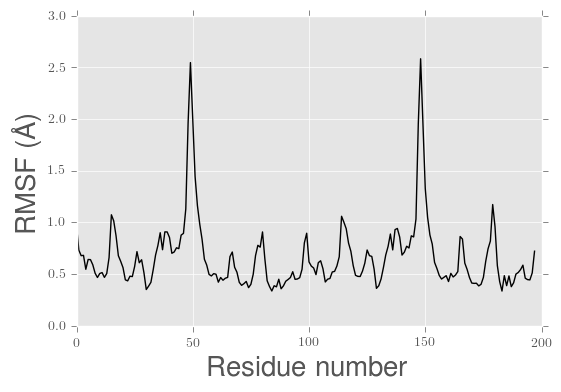

In [13]:
xx1 = np.std(caDevsMDall, 1);
rmsf_1 = np.mean(xx1.reshape((dim, Na)),0);
plt.plot(rmsf_1, 'k-');
plt.xlabel('Residue number', fontsize=20);
plt.ylabel('RMSF (\AA)', fontsize=20);
plt.show();

## Quantifying anharmonicity on a per-atom/per-residue basis

We quantify anharmonicity in atomic fluctuations using two approaches: (1) **Line 10-11**: the time spent by each atom (in $[x, y, z]$ directions) in the tails of the distributions (Figure in line 8) and (2) **Line 12-13**: per-residue/atom average $\kappa$ in $[x, y, z]$ directions. We also provide a simple routine to output PDB files for visualization using `b-factor` column in the standard PDB file. 

In [14]:
mm = caDevsMDall.mean(1);
md = caDevsMDall.std(1);
cntArray = np.zeros((594,1));
for i in range(0, caDevsMDall.shape[0]):
    y = caDevsMDall[i,:]
    b = filter(lambda x: (x >= (mm[i] + 2.5*md[i]) or x <= (mm[i] - 2.5*md[i])), y); 
    cntArray[i] = len(b);

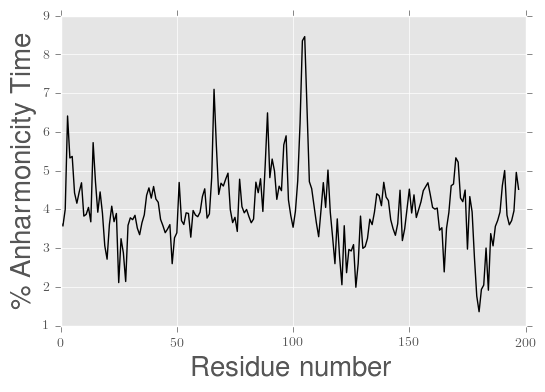

In [15]:
cntArray = cntArray.reshape((dim,Na));
bfactor = np.zeros((Na,1));
for i in range(0, Na):
    bfactor[i] = float(sum(cntArray[:,i]))*100/Nc;
plt.plot(bfactor, 'k-');
plt.xlabel('Residue number', fontsize=20);
plt.ylabel('\% Anharmonicity Time', fontsize=20);
plt.show();

fi = open('../../data/hivp.pdb', 'r');
fo = open('../../hivp_bfactors_timeSpentAnharmonic.pdb', 'w');
for line in fi.readlines():
    l = line.strip().split();
    if len(l) > 1:
        print >>fo, line[0:62], '%3.2f' %(bfactor[int(l[4])-1]);
fi.close();
fo.close();

(594, 25000)
(198, 1)


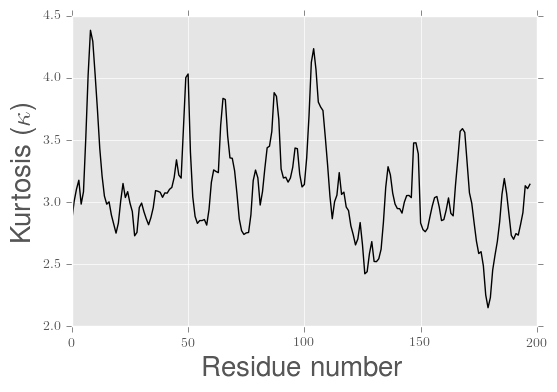

In [16]:
gK_Res = np.zeros((Na, 1)); print caDevsMDall.shape; print gK_Res.shape;
k = 0;
for i in range(0, gK_Res.shape[0]):
    kX = scipy.stats.kurtosis(caDevsMDall[i,:],0,fisher=False);
    kY = scipy.stats.kurtosis(caDevsMDall[i+1,:],0,fisher=False);
    kZ = scipy.stats.kurtosis(caDevsMDall[i+2,:],0,fisher=False);
    gK_Res[k] = np.mean([kX, kY, kZ],0);
    i = i + 3;
    k = k + 1;
plt.plot(gK_Res, 'k-');
plt.xlabel('Residue number', fontsize=20);
plt.ylabel('Kurtosis ($\kappa$)', fontsize=20);
plt.show();

In [17]:
fi = open('../../data/hivp.pdb', 'r');
fo = open('../../data/hivp_bfactors_perResidueKurtosis.pdb', 'w');
for line in fi.readlines():
    l = line.strip().split();
    if len(l) > 1:
        print >>fo, line[0:62], '%3.2f' %(gK_Res[int(l[4])-1]);
fi.close();
fo.close();